In [3]:
import pandas as pd
import seaborn as sns
from fastai.structured import *
from fastai.column_data import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
np.set_printoptions(threshold=50, edgeitems=20)

import gc
gc.enable()

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
PATH = "data/bondora/"

# Load Data

In [461]:
df = pd.read_csv(f"{PATH}public_report.csv", low_memory=False)

In [462]:
df = df.drop_duplicates()

In [200]:
len(df)

11827

In [463]:
df.defaultdate = df.defaultdate.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.biddingstartedon = df.biddingstartedon.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.debtoccuredon = df.debtoccuredon.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.debtoccuredonforsecondary = df.debtoccuredonforsecondary.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.loandate = df.loandate.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.firstpaymentdate = df.firstpaymentdate.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.lastpaymenton = df.lastpaymenton.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.maturitydate_last = df.maturitydate_last.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.maturitydate_original = df.maturitydate_original.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.contractenddate = df.contractenddate.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.dateofbirth = df.dateofbirth.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.graceperiodstart = df.graceperiodstart.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.graceperiodend = df.graceperiodstart.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.listedonutc = df.listedonutc.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.loanapplicationstarteddate = df.loanapplicationstarteddate.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
#df.stageactivesince = df.stageactivesince.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))
df.rescheduledon = df.rescheduledon.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S'))

In [464]:
add_datepart(df, "biddingstartedon", drop=False)
add_datepart(df, "loanapplicationstarteddate", drop=False)
add_datepart(df, "loandate", drop=False)
add_datepart(df, "dateofbirth", drop=False)
add_datepart(df, "defaultdate", drop=False)

In [91]:
df.reset_index(drop=True, inplace=True)

In [92]:
df.to_feather(f"{PATH}df")

In [28]:
df = pd.read_feather(f"{PATH}df")

# Spot the differences

<IPython.core.display.Javascript object>


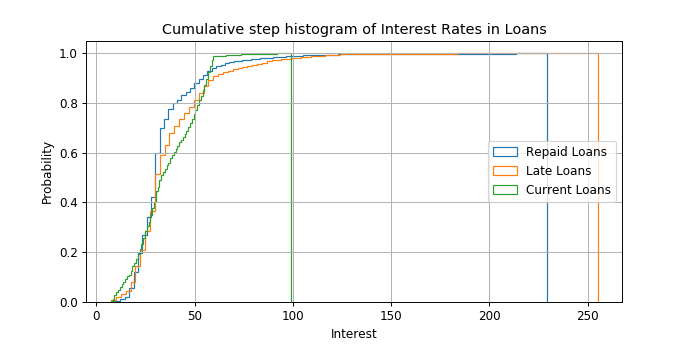

In [66]:
%matplotlib notebook
%matplotlib notebook

x1 = df.loc[df['status'] == 'Repaid'].interest.values
x2 = df.loc[df['status'] == 'Late'].interest.values
x3 = df.loc[df['status'] == 'Current'].interest.values

n_bins = 100

fig, ax = plt.subplots(figsize=(8, 4))

# plot the cumulative histogram
n, bins, patches = ax.hist(x1, n_bins, density=True, histtype='step',
                           cumulative=True, label='Repaid Loans')

n, bins, patches = ax.hist(x2, n_bins, density=True, histtype='step',
                           cumulative=True, label='Late Loans')

n, bins, patches = ax.hist(x3, n_bins, density=True, histtype='step',
                           cumulative=True, label='Current Loans')


# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Cumulative step histogram of Interest Rates in Loans')
ax.set_xlabel('Interest')
ax.set_ylabel('Probability')

plt.show()

In [43]:
max_value = np.array([len(df.loc[df['status'] == 'Repaid']), len(df.loc[df['status'] == 'Current']), len(df.loc[df['status'] == 'Late'])]).max()

same_length_dict = {}

for status in df.status.unique():
    a = np.zeros(max_value)
    a[:len(df.loc[df['status'] == status].amount.values)] = df.loc[df['status'] == status].amount.values
    a[len(df.loc[df['status'] == status].amount.values):] = np.nan
    same_length_dict[status] = a

dist = pd.DataFrame({'Amount in Repaid Loans':same_length_dict['Repaid'], 
                     'Amount in Late Loans':same_length_dict['Late'],
                     'Amount in Current Loans':same_length_dict['Current']})


dist.agg(['min', 'max', 'mean', 'std']).round()

,Amount in Repaid Loans,Amount in Late Loans,Amount in Current Loans
min,375.0,460.0,500.0
max,10630.0,10630.0,10630.0
mean,3229.0,3209.0,3162.0
std,2129.0,2143.0,2330.0


In [45]:
for status in df.status.unique():
    a = np.zeros(max_value)
    a[:len(df.loc[df['status'] == status].interest.values)] = df.loc[df['status'] == status].interest.values
    a[len(df.loc[df['status'] == status].interest.values):] = np.nan
    same_length_dict[status] = a

dist = pd.DataFrame({'Interest in Repaid Loans':same_length_dict['Repaid'], 
                     'Interest in Late Loans':same_length_dict['Late'],
                     'Interest in Current Loans':same_length_dict['Current']})


dist.agg(['min', 'max', 'mean', 'std']).round()

,Interest in Repaid Loans,Interest in Late Loans,Interest in Current Loans
min,8.0,7.0,7.0
max,229.0,255.0,99.0
mean,35.0,38.0,36.0
std,17.0,21.0,15.0


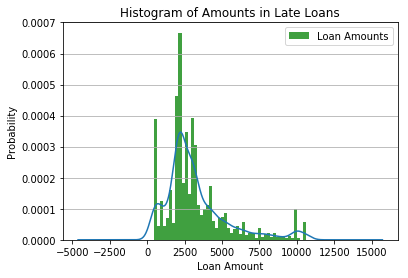

In [81]:
%matplotlib inline

dist = pd.DataFrame(df.loc[df['status'] == 'Late'].amount.values, columns=['Loan Amounts'])
fig, ax = plt.subplots()
dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=50, facecolor='g', alpha=0.75, ax=ax, title='Histogram of Amounts in Late Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('Loan Amount')
ax.grid(axis='y')

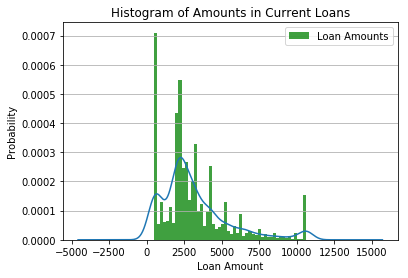

In [82]:
%matplotlib inline

dist = pd.DataFrame(df.loc[df['status'] == 'Current'].amount.values, columns=['Loan Amounts'])
fig, ax = plt.subplots()
dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=50, facecolor='g', alpha=0.75, ax=ax, title='Histogram of Amounts in Current Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('Loan Amount')
ax.grid(axis='y')

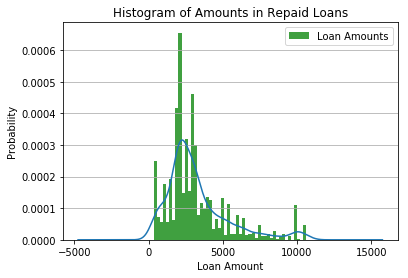

In [83]:
%matplotlib inline

dist = pd.DataFrame(df.loc[df['status'] == 'Repaid'].amount.values, columns=['Loan Amounts'])
fig, ax = plt.subplots()
dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=50, facecolor='g', alpha=0.75, ax=ax, title='Histogram of Amounts in Repaid Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('Loan Amount')
ax.grid(axis='y')

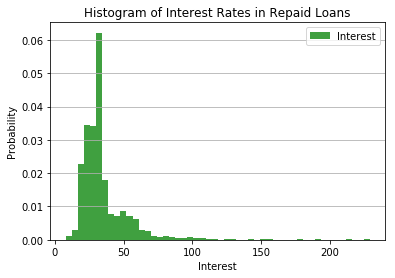

In [87]:
%matplotlib inline

dist = pd.DataFrame(df.loc[df['status'] == 'Repaid'].interest.values, columns=['Interest'])
fig, ax = plt.subplots()
#dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=50, facecolor='g', alpha=0.75, ax=ax, title='Histogram of Interest Rates in Repaid Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('Interest')
ax.grid(axis='y')

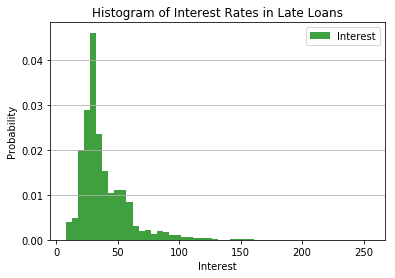

In [88]:
%matplotlib inline

dist = pd.DataFrame(df.loc[df['status'] == 'Late'].interest.values, columns=['Interest'])
fig, ax = plt.subplots()
#dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=50, facecolor='g', alpha=0.75, ax=ax, title='Histogram of Interest Rates in Late Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('Interest')
ax.grid(axis='y')

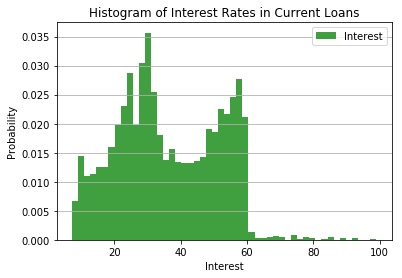

In [89]:
%matplotlib inline

dist = pd.DataFrame(df.loc[df['status'] == 'Current'].interest.values, columns=['Interest'])
fig, ax = plt.subplots()
#dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=50, facecolor='g', alpha=0.75, ax=ax, title='Histogram of Interest Rates in Current Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('Interest')
ax.grid(axis='y')

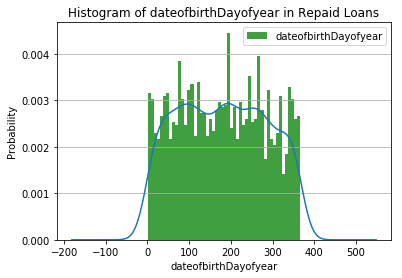

In [90]:
%matplotlib inline

dist = pd.DataFrame(df.loc[df['status'] == 'Repaid'].dateofbirthDayofyear.values, columns=['dateofbirthDayofyear'])
fig, ax = plt.subplots()
dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=50, facecolor='g', alpha=0.75, ax=ax, title='Histogram of dateofbirthDayofyear in Repaid Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('dateofbirthDayofyear')
ax.grid(axis='y')

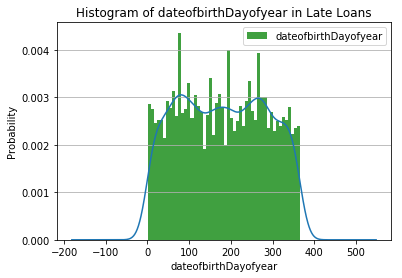

In [101]:
%matplotlib inline

dist = pd.DataFrame(df.loc[df['status'] == 'Late'].dateofbirthDayofyear.values, columns=['dateofbirthDayofyear'])
fig, ax = plt.subplots()
dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=50, facecolor='g', alpha=0.75, ax=ax, title='Histogram of dateofbirthDayofyear in Late Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('dateofbirthDayofyear')
ax.grid(axis='y')

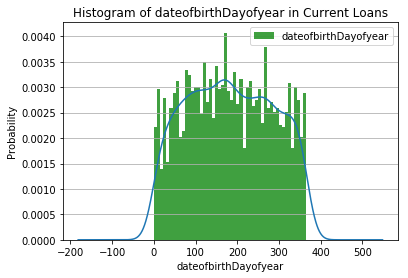

In [100]:
%matplotlib inline

dist = pd.DataFrame(df.loc[df['status'] == 'Current'].dateofbirthDayofyear.values, columns=['dateofbirthDayofyear'])
fig, ax = plt.subplots()
dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=50, facecolor='g', alpha=0.75, ax=ax, title='Histogram of dateofbirthDayofyear in Current Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('dateofbirthDayofyear')
ax.grid(axis='y')

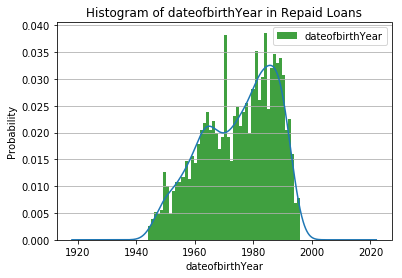

In [104]:
%matplotlib inline

dist = pd.DataFrame(df.loc[df['status'] == 'Repaid'].dateofbirthYear.values, columns=['dateofbirthYear'])
fig, ax = plt.subplots()
dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=50, facecolor='g', alpha=0.75, ax=ax, title='Histogram of dateofbirthYear in Repaid Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('dateofbirthYear')
ax.grid(axis='y')

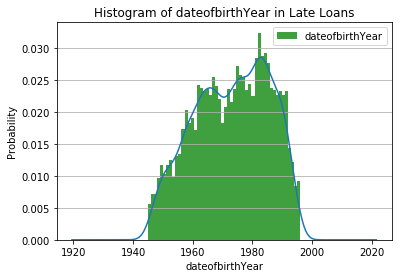

In [105]:
%matplotlib inline

dist = pd.DataFrame(df.loc[df['status'] == 'Late'].dateofbirthYear.values, columns=['dateofbirthYear'])
fig, ax = plt.subplots()
dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=50, facecolor='g', alpha=0.75, ax=ax, title='Histogram of dateofbirthYear in Late Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('dateofbirthYear')
ax.grid(axis='y')

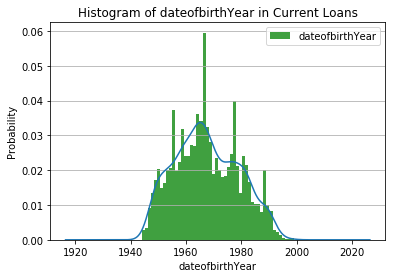

In [106]:
%matplotlib inline

dist = pd.DataFrame(df.loc[df['status'] == 'Current'].dateofbirthYear.values, columns=['dateofbirthYear'])
fig, ax = plt.subplots()
dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=50, facecolor='g', alpha=0.75, ax=ax, title='Histogram of dateofbirthYear in Current Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('dateofbirthYear')
ax.grid(axis='y')

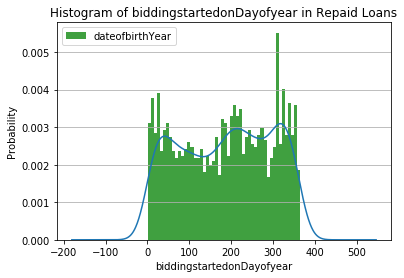

In [107]:
%matplotlib inline

dist = pd.DataFrame(df.loc[df['status'] == 'Repaid'].biddingstartedonDayofyear.values, columns=['dateofbirthYear'])
fig, ax = plt.subplots()
dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=50, facecolor='g', alpha=0.75, ax=ax, title='Histogram of biddingstartedonDayofyear in Repaid Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('biddingstartedonDayofyear')
ax.grid(axis='y')

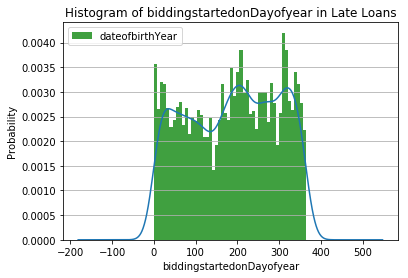

In [108]:
%matplotlib inline

dist = pd.DataFrame(df.loc[df['status'] == 'Late'].biddingstartedonDayofyear.values, columns=['dateofbirthYear'])
fig, ax = plt.subplots()
dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=50, facecolor='g', alpha=0.75, ax=ax, title='Histogram of biddingstartedonDayofyear in Late Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('biddingstartedonDayofyear')
ax.grid(axis='y')

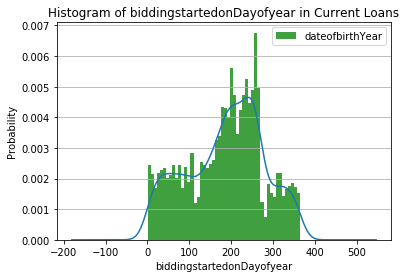

In [109]:
%matplotlib inline

dist = pd.DataFrame(df.loc[df['status'] == 'Current'].biddingstartedonDayofyear.values, columns=['dateofbirthYear'])
fig, ax = plt.subplots()
dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=50, facecolor='g', alpha=0.75, ax=ax, title='Histogram of biddingstartedonDayofyear in Current Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('biddingstartedonDayofyear')
ax.grid(axis='y')

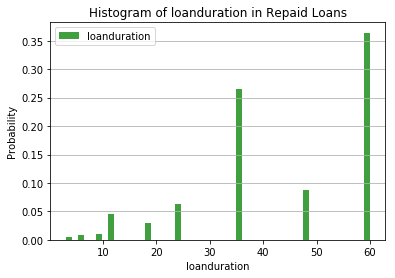

In [456]:
%matplotlib inline

dist = pd.DataFrame(df.loc[df['status'] == 'Repaid'].loanduration.values, columns=['loanduration'])
fig, ax = plt.subplots()
#dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=50, facecolor='g', alpha=0.75, ax=ax, title='Histogram of loanduration in Repaid Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('loanduration')
ax.grid(axis='y')

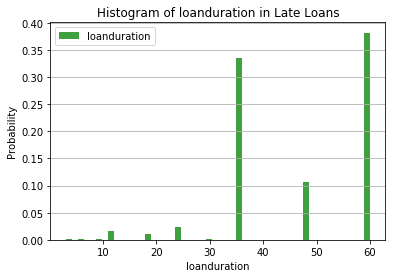

In [457]:
%matplotlib inline

dist = pd.DataFrame(df.loc[df['status'] == 'Late'].loanduration.values, columns=['loanduration'])
fig, ax = plt.subplots()
#dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=50, facecolor='g', alpha=0.75, ax=ax, title='Histogram of loanduration in Late Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('loanduration')
ax.grid(axis='y')

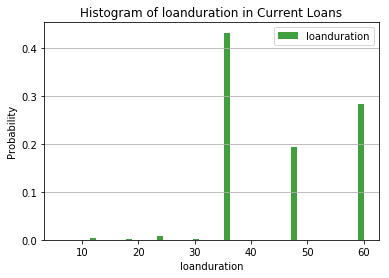

In [459]:
%matplotlib inline

dist = pd.DataFrame(df.loc[df['status'] == 'Current'].loanduration.values, columns=['loanduration'])
fig, ax = plt.subplots()
#dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=50, facecolor='g', alpha=0.75, ax=ax, title='Histogram of loanduration in Current Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('loanduration')
ax.grid(axis='y')

# Default Rates and Trends

In [113]:
df.groupby(['loanYear']).size()

loanYear
2013     165
2014    1408
2015    2360
2016    1849
2017    2650
2018    3395
dtype: int64

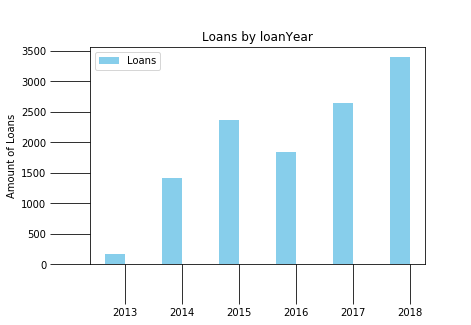

In [122]:
sizes = [i for i in df.groupby('loanYear').size()]
groups = list(df.groupby('loanYear').groups.keys())
group_d = {k:v for k,v in zip(groups, sizes)}

group_sizes = group_d.values()
ind = np.arange(len(group_d)) # the x locations for the groups
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects = ax.bar(ind - width/2, group_sizes, width, 
                color='SkyBlue', label='Loans')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Amount of Loans')
ax.set_title('Loans by loanYear')
ax.set_xticks(ind)
ax.set_xticklabels(group_d.keys())
ax.tick_params(length=40)
ax.legend()

plt.show()

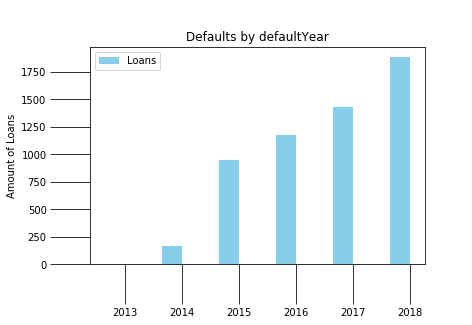

In [138]:
sizes = [i for i in df.groupby('defaultYear').size()]
groups = [int(i) for i in df.groupby('defaultYear').groups.keys()]
group_d = {k:v for k,v in zip(groups, sizes)}

group_sizes = group_d.values()
ind = np.arange(len(group_d)) # the x locations for the groups
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects = ax.bar(ind - width/2, group_sizes, width, 
                color='SkyBlue', label='Loans')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Amount of Loans')
ax.set_title('Defaults by defaultYear')
ax.set_xticks(ind)
ax.set_xticklabels(group_d.keys())
ax.tick_params(length=40)
ax.legend()

plt.show()

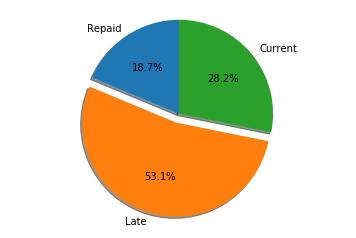

In [152]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Repaid', 'Late', 'Current'

sizes = len(df.loc[df['status'] == 'Repaid']), len(df.loc[df['status'] == 'Late']), len(df.loc[df['status'] == 'Current'])
explode = (0, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Late')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

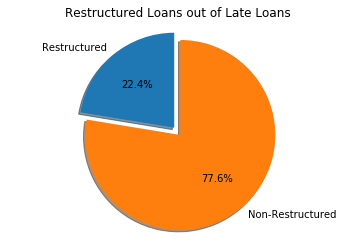

In [542]:
late_restructured = (df.loc[df['status'] == 'Late'].restructured.values)*1
late_restructured = late_restructured.sum()
late = len(df.loc[df['status'] == 'Late'])

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Restructured', 'Non-Restructured'

sizes = late_restructured, late
explode = (0.1, 0)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Restructured Loans out of Late Loans')
plt.show()

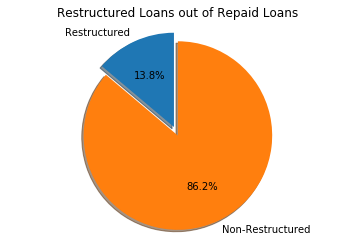

In [543]:
repaid_restructured = (df.loc[df['status'] == 'Repaid'].restructured.values)*1
repaid_restructured = repaid_restructured.sum()
repaid = len(df.loc[df['status'] == 'Repaid'])

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Restructured', 'Non-Restructured'

sizes = repaid_restructured, repaid
explode = (0.1, 0) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Restructured Loans out of Repaid Loans')
plt.show()

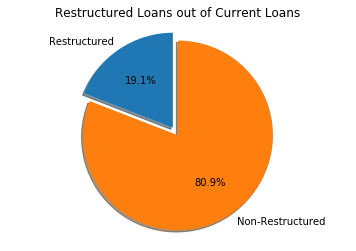

In [544]:
current_restructured = (df.loc[df['status'] == 'Current'].restructured.values)*1
current_restructured = current_restructured.sum()
current = len(df.loc[df['status'] == 'Current'])

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Restructured', 'Non-Restructured'

sizes = current_restructured, current
explode = (0.1, 0) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Restructured Loans out of Current Loans')
plt.show()

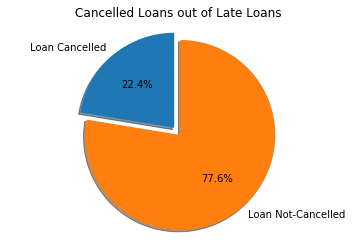

In [547]:
cancelled = (df.loc[df['status'] == 'Late'].loancancelled.values)*1
cancelled = cancelled.sum()
late = len(df.loc[df['status'] == 'Late'])

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Loan Cancelled', 'Loan Not-Cancelled'

sizes = late_restructured, late
explode = (0.1, 0)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Cancelled Loans out of Late Loans')
plt.show()

#### Default rates by year and loan duration 

In [468]:
years = df['loanYear'].unique()
year_loanduration_d = {}
for i in years:
    durations = df.loanduration.unique()
    durations.sort()
    year_loanduration_d[i] = durations

In [469]:
Timestamp=np.datetime64
currentdate = Timestamp('2018-10-05 12:00:00')

In [470]:
combinations = []

for k,v in year_loanduration_d.items():
    for i in v:
        all_loans = len(df.loc[(df['loanYear'] == k) & (df['loanduration'] == i)])
        late_loans = len(df.loc[(df['loanYear'] == k) & (df['loanduration'] == i) & (df['status'] == 'Late')])
        if all_loans != 0:
            late_ratio = np.around(late_loans/all_loans, 2)
            combinations.append([k, i, late_ratio])
        else:
            combinations.append([k, i, np.nan])

In [471]:
years = []
loandurations = []
late_ratios = []

for i in combinations:
    years.append(i[0])
    loandurations.append(i[1])
    late_ratios.append(i[2])

In [472]:
len(years), len(loandurations), len(late_ratios)

(60, 60, 60)

In [473]:
late_df = pd.DataFrame({'loanyear':years, 'loanduration':loandurations, 'late_ratio':late_ratios})
late_ratios = late_df.sort_values(by=['loanyear', 'loanduration'])['late_ratio'].values.reshape((len(late_df.loanduration.unique()), len(late_df.loanyear.unique())))

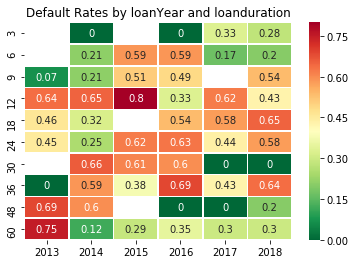

In [591]:
%matplotlib inline

idx = sorted(list(late_df.loanduration.unique()))
cols = sorted(list(late_df.loanyear.unique()))
heat_df = pd.DataFrame(late_ratios, index=idx, columns=cols)

# _r reverses the normal order of the color map 'RdYlGn'
plt.title('Default Rates by loanYear and loanduration')
sns.heatmap(heat_df, cmap='RdYlGn_r', linewidths=0.5, annot=True)
plt.show()

# Interest rate vs. loan duration

In [153]:
df1 = df[['interest','loanduration']].round()
df1 = df1.groupby(['interest','loanduration']).count()
df1 = list(df1.index)

In [414]:
y = df.loc[df['status'] == 'Late']['interest'].round().values
x = df.loc[df['status'] == 'Late']['loanduration'].values

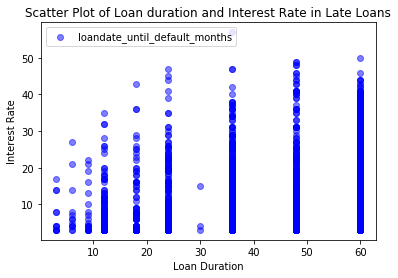

In [595]:
plt.scatter(x, y, c="b", alpha=0.5)
plt.ylabel("Interest Rate")
plt.xlabel("Loan Duration")
plt.legend(loc='upper left')
plt.title('Scatter Plot of Loan duration and Interest Rate in Late Loans')
plt.show()

In [416]:
y = df.loc[df['status'] == 'Repaid']['interest'].round().values
x = df.loc[df['status'] == 'Repaid']['loanduration'].values

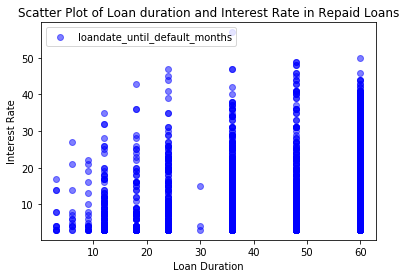

In [596]:
plt.scatter(x, y, c="b", alpha=0.5)
plt.ylabel("Interest Rate")
plt.xlabel("Loan Duration")
plt.legend(loc='upper left')
plt.title('Scatter Plot of Loan duration and Interest Rate in Repaid Loans')
plt.show()

In [418]:
y = df.loc[df['status'] == 'Current']['interest'].round().values
x = df.loc[df['status'] == 'Current']['loanduration'].values

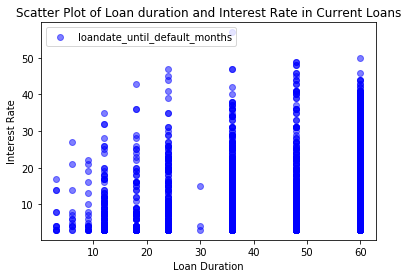

In [597]:
plt.scatter(x, y, c="b", alpha=0.5)
plt.ylabel("Interest Rate")
plt.xlabel("Loan Duration")
plt.legend(loc='upper left')
plt.title('Scatter Plot of Loan duration and Interest Rate in Current Loans')
plt.show()


# How long does it take until default happens?

In [475]:
defaultdates = list(df.defaultdate.values)
loandates = list(df.loandate.values)

In [476]:
loandate_until_default_days = [b-a for a,b in zip(loandates, defaultdates)]
loandate_until_default_months = [x.astype('timedelta64[M]')/np.timedelta64(1, 'M') for x in loandate_until_default_days]
df['loandate_until_default_months'] = loandate_until_default_months

In [477]:
y = df.loc[df['loandate_until_default_months'].notnull()]['loandate_until_default_months']
x = df.loc[df['loandate_until_default_months'].notnull()]['loanduration']       

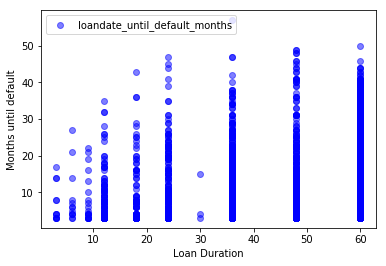

In [594]:
plt.scatter(x, y, c="b", alpha=0.5)
plt.ylabel("Months until default")
plt.xlabel("Loan Duration")
plt.legend(loc='upper left')
plt.show()

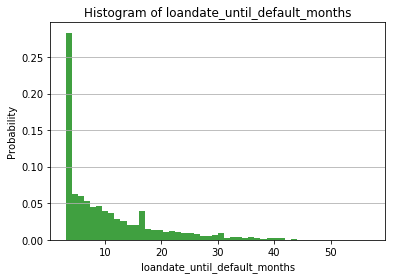

In [592]:
%matplotlib inline

dist = df.loc[df['loandate_until_default_months'].notnull()]['loandate_until_default_months']
fig, ax = plt.subplots()
#dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=50, facecolor='g', alpha=0.75, ax=ax, title='Histogram of loandate_until_default_months')
ax.set_ylabel('Probability')
ax.set_xlabel('loandate_until_default_months')
ax.grid(axis='y')

#### Monthly payments

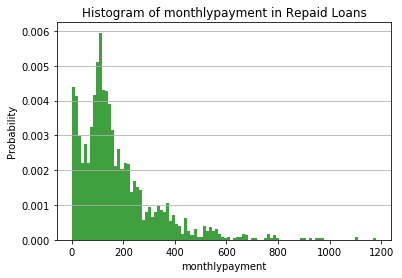

In [512]:
%matplotlib inline

dist = df.loc[(df['monthlypayment'].notnull()) & (df['status'] == 'Repaid')]['monthlypayment']
fig, ax = plt.subplots()
#dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=100, facecolor='g', alpha=0.75, ax=ax, title='Histogram of monthlypayment in Repaid Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('monthlypayment')
ax.grid(axis='y')

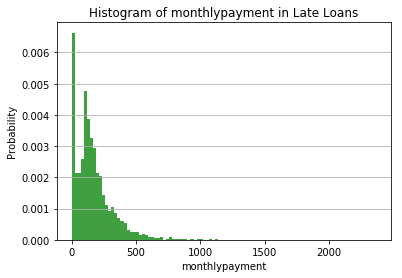

In [511]:
%matplotlib inline

dist = df.loc[(df['monthlypayment'].notnull()) & (df['status'] == 'Late')]['monthlypayment']
fig, ax = plt.subplots()
#dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=100, facecolor='g', alpha=0.75, ax=ax, title='Histogram of monthlypayment in Late Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('monthlypayment')
ax.grid(axis='y')

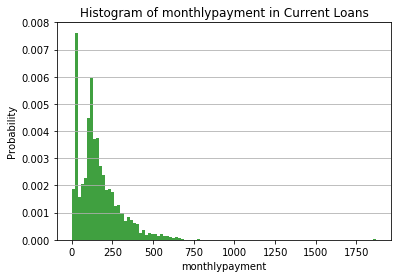

In [513]:
%matplotlib inline

dist = df.loc[(df['monthlypayment'].notnull()) & (df['status'] == 'Current')]['monthlypayment']
fig, ax = plt.subplots()
#dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=100, facecolor='g', alpha=0.75, ax=ax, title='Histogram of monthlypayment in Current Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('monthlypayment')
ax.grid(axis='y')

# How much of the capital has been repaid in late loans?

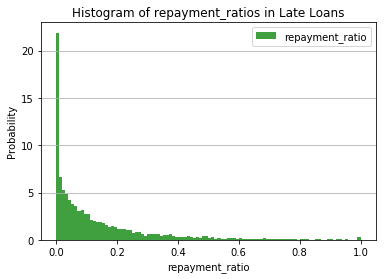

In [593]:
%matplotlib inline

principalpaymentsmade_l = df.loc[df['status'] == 'Late']['principalpaymentsmade'].values
amount_l = df.loc[df['status'] == 'Late']['amount'].values
repayment_ratios = [a/b for a,b in zip(principalpaymentsmade_l, amount_l)]
dist = pd.DataFrame(repayment_ratios, columns=['repayment_ratio'])

fig, ax = plt.subplots()
#dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=100, facecolor='g', alpha=0.75, ax=ax, title='Histogram of repayment_ratios in Late Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('repayment_ratio')
ax.grid(axis='y')

# Borrower data

In [252]:
len(df.loc[df['gender'] == 0]), len(df.loc[df['gender'] == 1])

(8178, 3649)

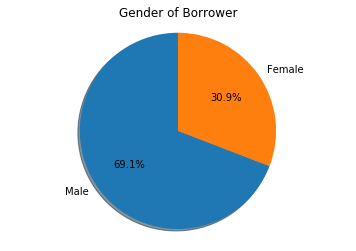

In [556]:
male = len(df.loc[df['gender'] == 0])
female = len(df.loc[df['gender'] == 1])


# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Male', 'Female'

sizes = male, female  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Gender of Borrower')
plt.show()

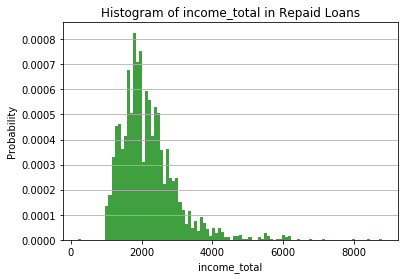

In [563]:
%matplotlib inline

dist = df.loc[(df['status'] == 'Repaid') & (df['incometotal'] < 10000)]['incometotal']

fig, ax = plt.subplots()
#dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=100, facecolor='g', alpha=0.75, ax=ax, title='Histogram of income_total in Repaid Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('income_total')
ax.grid(axis='y')


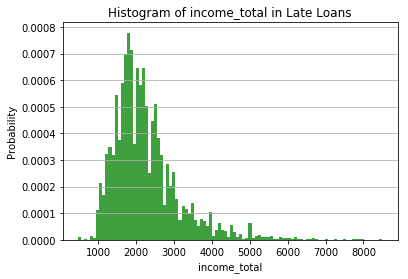

In [562]:
%matplotlib inline

dist = df.loc[(df['status'] == 'Late') & (df['incometotal'] < 10000)]['incometotal']

fig, ax = plt.subplots()
#dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=100, facecolor='g', alpha=0.75, ax=ax, title='Histogram of income_total in Late Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('income_total')
ax.grid(axis='y')

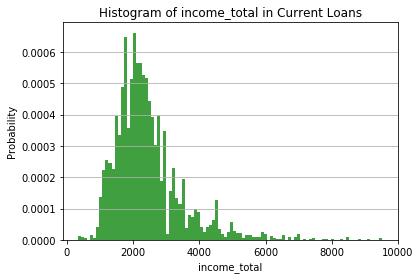

In [564]:
%matplotlib inline

dist = df.loc[(df['status'] == 'Current') & (df['incometotal'] < 10000)]['incometotal']

fig, ax = plt.subplots()
#dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=100, facecolor='g', alpha=0.75, ax=ax, title='Histogram of income_total in Current Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('income_total')
ax.grid(axis='y')

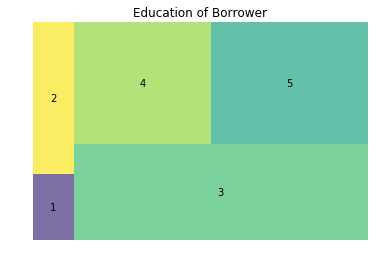

In [601]:
import squarify   
 
sizes = [i for i in df.groupby('education').size()]
groups = [int(i) for i in df.groupby('education').groups.keys()]

squarify.plot(sizes=sizes, label=groups, alpha=.7 )
plt.axis('off')
plt.title('Education of Borrower')
plt.show()

In [614]:
positions = df.loc[df['education']== 2]['employmentposition'].unique()
print(f'Education = 2. Employment positions: {positions}')

Education = 2. Employment positions: ['Pensioner' 'Worker' 'Owner' 'MiddleManager' 'SpecialistOfficeWorker' 'rakentaja' 'Laitoshuoltaja'
 'Elintarviken työntekijä' 'elintarviketyöläinen' 'eläkeläinen' 'ehitaja' 'lapsehoidja' 'Katusemeister'
 'koristaja' 'Materiaalikoneen kulj.' 'koristaja - hooldustöötaja' 'pensionär' 'palveluohjaaja'
 'henkilökohtainen avustaja' 'Pensionär' ... 'Harvestery operaator' 'metallitöömees' 'osa-aikaeläke' nan
 'Työnjohtaja/Rakennus mies' 'Särmäyksen valokuvaaja' 'Laitosapulainen' 'Myyjä' 'Varhaisjakaaja'
 'Potilaskuljettaja' 'Automyyjä' 'Toimihenkilö' 'Rakennusmies' 'Peltiseppä' 'Rakentaja'
 'parturi/kotona lasten kanssa' 'kioskin vastaava' 'SuperiorSpecialist' 'Housewife' 'Executive']


In [619]:
positions = df.loc[df['education']== 1]['employmentposition'].unique()
print(f'Education = 1. Employment positions: {positions}')

Education = 1. Employment positions: ['Painotyönjohtaja' 'Müüntineuvotelija' 'Liikennemyymälätyöntekijä' 'Datanomi' nan 'SpecialistOfficeWorker'
 'Worker' 'Pensioner' 'Owner']


In [618]:
positions = df.loc[df['education']== 3]['employmentposition'].unique()
print(f'Education = 3. Employment positions: {positions}')

Education = 3. Employment positions: ['Worker' 'SpecialistOfficeWorker' 'Pensioner' 'MiddleManager' 'Executive' 'Owner' 'Bussijuht' 'Koristaja'
 'Siivoja' 'postityöntekijä' 'ekskavaatorijuht' 'abistaja-lastehoidja' 'restorani töötaja' 'puusepp'
 'majahoidja' 'koristaja' 'metallimies' 'ravitsemustyöntekijä' 'lähihoitaja' 'Toimitilahuoltaja' ...
 'Vastanottaja virkailija' 'Siivous työnohjaaja ' 'Sähköasentaja' 'Koneenkuljettaja' 'Tuotannon suunnitalija'
 'Siivooja' 'Kirvesmies' 'Käytön tarkkailija' 'Kotiaputyöntekijä' 'Koneenhoitaja' 'Erityislasten hoitaja.'
 'Juuksur' 'Hoitoapulainen' 'Elintarviken työntekijä' 'Vartija' 'Hiekkapuhaltaja' 'SuperiorSpecialist'
 'Unemployed' 'Student' 'Housewife']


In [615]:
positions = df.loc[df['education']== 4]['employmentposition'].unique()
print(f'Education = 4. Employment positions: {positions}')

Education = 4. Employment positions: ['SuperiorSpecialist' 'Pensioner' 'Worker' 'MiddleManager' 'SpecialistOfficeWorker' 'Owner' 'Krediidihaldur'
 'Sairanhoitaja' 'Huoltokotin erikoishoitaja' 'Järjestelmän päälikö' 'Elintarviken työntekijä' 'TH-vastaava'
 'Rotatio työntekijä' 'Kartanon kotiinhoitaja' nan 'hevosajeluita tilauksesta ' 'ravintola vastaava'
 'Kokkupanija. ' 'sekretär' 'konemies' ... 'puusepp' 'Parketiasentaija' 'IT -arkitehti ' 'Koristaja '
 'Työntekijä' 'Lähihoitaja ' 'neuvottelijä' 'Osastonsihteeri' 'Pukuhuoltaja' 'Auto puhastaja'
 'Asiakaspalvelija' 'Ravintolapäällikkö' 'Johtaja' 'Järjestelmäasiantuntija' 'Myyntipäällikkö'
 'Projekti suunnittelija' 'Maalari' 'Linja-autonkuljettaja' 'Executive' 'Student']


In [616]:
positions = df.loc[df['education']== 5]['employmentposition'].unique()
print(f'Education = 5. Employment positions: {positions}')

Education = 5. Employment positions: ['SpecialistOfficeWorker' 'MiddleManager' 'SuperiorSpecialist' 'Executive' 'Worker' 'Pensioner' 'Owner'
 'hallintojohtaja' 'Suuhygienisti' 'Aluen johtaja' 'cleaning' 'geronom' 'projekti-insinööri'
 'toimitusjohtaja' 'nõudepesija' 'ettevõtluse arendamise juht' 'arst' 'bussijuht' 'hooldustöötaja'
 'OFFICE ASSISTANT' ... 'Työkeskuksen johtaja' 'tutkija' 'Vero tarkastaja' ' Kokki/Tarjoilija'
 'Taksin kuljettaja' 'Asiakas neuvoja' 'Näyttelijä' 'Huoltopäällikkö' 'Aluejohtaja' 'Vastaava yöntyöntekijä'
 'Psykologi' 'Osastoupseeri' 'Keskastme juht' 'Projektipäälllikkö' 'Tekninen asiakaspalvelija'
 'Päiväkodin johtaaja.' 'Luokanopettaja' 'Student' 'Unemployed' 'Housewife']


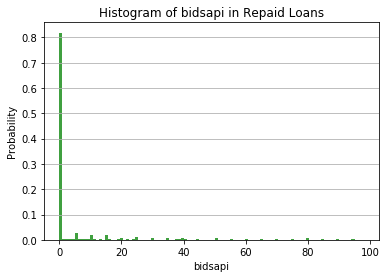

In [582]:
%matplotlib inline

dist = df.loc[(df['status'] == 'Repaid') & (df['bidsapi'] < 100)]['bidsapi']

fig, ax = plt.subplots()
#dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=100, facecolor='g', alpha=0.75, ax=ax, title='Histogram of bidsapi in Repaid Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('bidsapi')
ax.grid(axis='y')

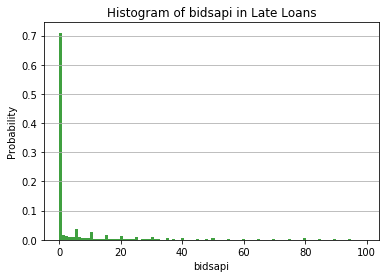

In [583]:
%matplotlib inline

dist = df.loc[(df['status'] == 'Late') & (df['bidsapi'] < 100)]['bidsapi']

fig, ax = plt.subplots()
#dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=100, facecolor='g', alpha=0.75, ax=ax, title='Histogram of bidsapi in Late Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('bidsapi')
ax.grid(axis='y')

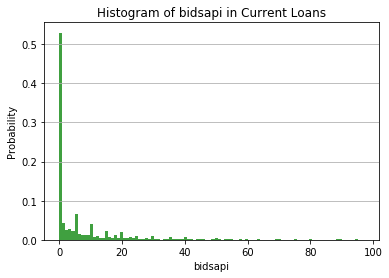

In [581]:
%matplotlib inline

dist = df.loc[(df['status'] == 'Current') & (df['bidsapi'] < 100)]['bidsapi']

fig, ax = plt.subplots()
#dist.plot.kde(ax=ax, legend=False)

dist.plot.hist(density=True, bins=100, facecolor='g', alpha=0.75, ax=ax, title='Histogram of bidsapi in Current Loans')
ax.set_ylabel('Probability')
ax.set_xlabel('bidsapi')
ax.grid(axis='y')